In [1]:
import numpy as np
import matplotlib.pyplot as plt

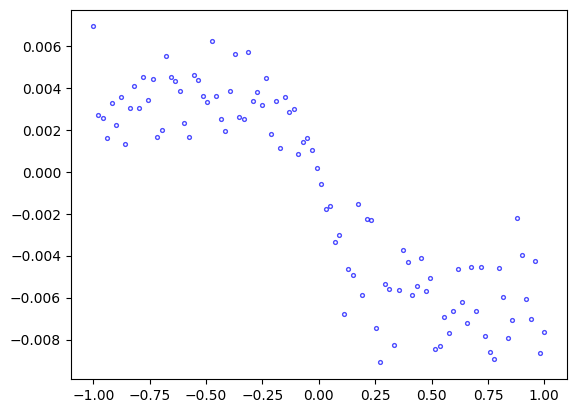

In [2]:
data = np.load("currents.npz")
currents = data["currents"]

voltages = np.linspace(-1., 1., currents.shape[0])

plt.scatter(voltages, currents, s=7.5, edgecolors="blue", facecolor="w", alpha=.7)

(20, 7)
(20, 1)


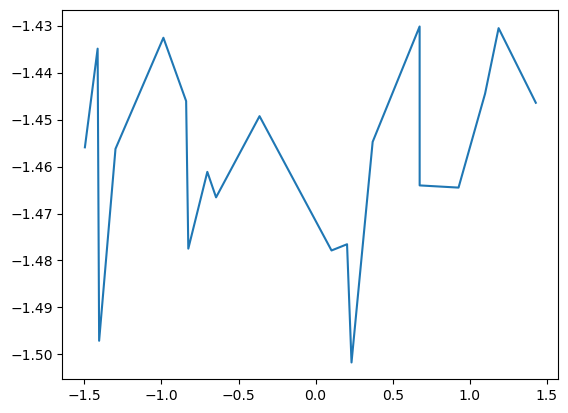

In [24]:
batch = np.load("currentData/batch1.npz")

print(batch["inputs"].shape)
print(batch["outputs"].shape)

plt.plot(np.sort(batch["inputs"][:,5]), batch["outputs"])